# N-BEATS 

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from darts import TimeSeries

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (9,6)

In [3]:
df = pd.read_csv('data/daily_min_temp.csv')

df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [4]:
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
series = TimeSeries.from_dataframe(df, time_col='Date', value_cols=['Temp'], fill_missing_dates=True, freq='d')

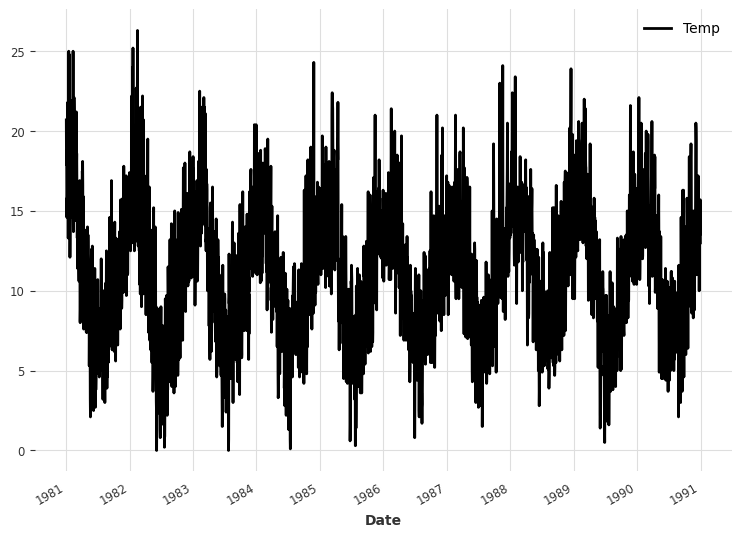

In [7]:
series.plot()

In [8]:
print(len(series))
print(len(df))

3652
3650


In [9]:
from darts.utils.missing_values import fill_missing_values

full_series = fill_missing_values(series)

## Train/test split 

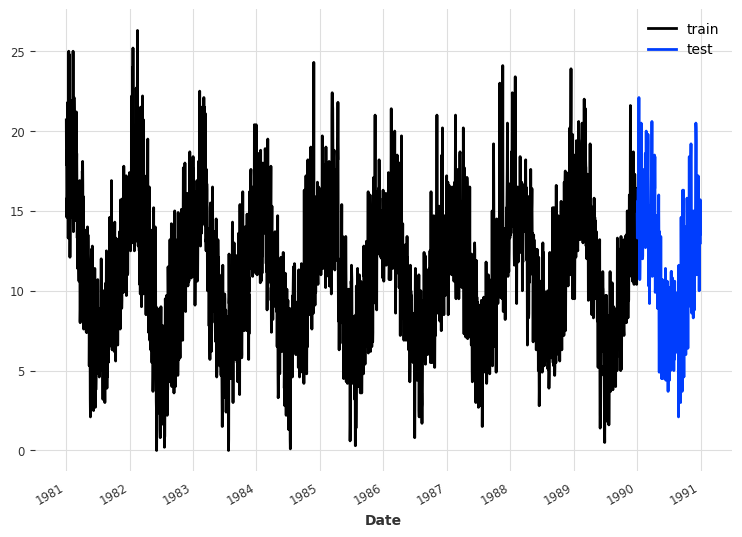

In [10]:
train, test = full_series[:-365], full_series[-365:]

train.plot(label='train')
test.plot(label='test')

## Baseline 

In [11]:
from darts.models.forecasting.baselines import NaiveSeasonal

naive_seasonal = NaiveSeasonal(K=365)
naive_seasonal.fit(train)

pred_naive = naive_seasonal.predict(365)

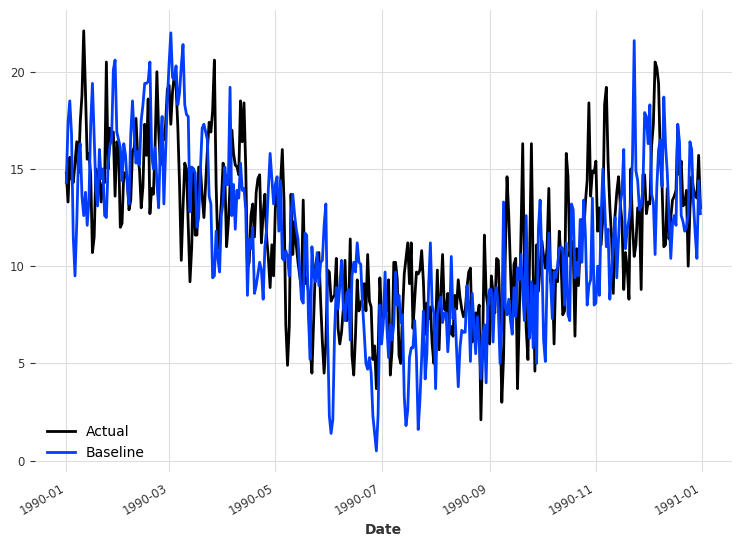

In [12]:
test.plot(label='Actual')
pred_naive.plot(label='Baseline')

## N-BEATS 

In [13]:
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler

train_scaler = Scaler()
scaled_train = train_scaler.fit_transform(train)

nbeats = NBEATSModel(
    input_chunk_length=365, 
    output_chunk_length=365,
    generic_architecture=True,
    random_state=42)

nbeats.fit(
    scaled_train,
    epochs=15
)

2023-01-26 18:12:23 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2023-01-26 18:12:23 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2023-01-26 18:12:23 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2023-01-26 18:12:23 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2023-01-26 18:12:23 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 8.9 M 
---------------------------------------------------
8.9 M     Trainable params
3.5 K     Non-trainable params
8.9 M     Total params
71.525    Total estimated model params size (MB)


Epoch 14: 100%|█████████████████████████████████████████| 80/80 [00:11<00:00,  6.94it/s, loss=0.0118, train_loss=0.012]

2023-01-26 18:15:19 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|█████████████████████████████████████████| 80/80 [00:11<00:00,  6.94it/s, loss=0.0118, train_loss=0.012]


In [14]:
scaled_pred_nbeats = nbeats.predict(n=365)

pred_nbeats = train_scaler.inverse_transform(scaled_pred_nbeats)

Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.84it/s]


### Evaluation 

In [15]:
from darts.metrics import mae

naive_mae = mae(test, pred_naive)
nbeats_mae = mae(test, pred_nbeats)

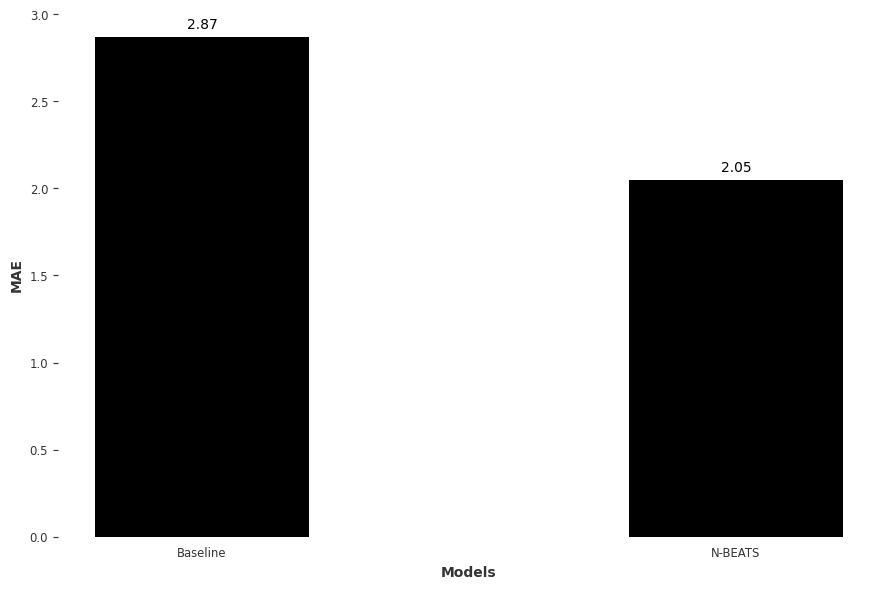

In [16]:
fig, ax = plt.subplots()

x = ['Baseline', 'N-BEATS']
y = [naive_mae, nbeats_mae]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')
ax.grid(False)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

### Plot predictions 

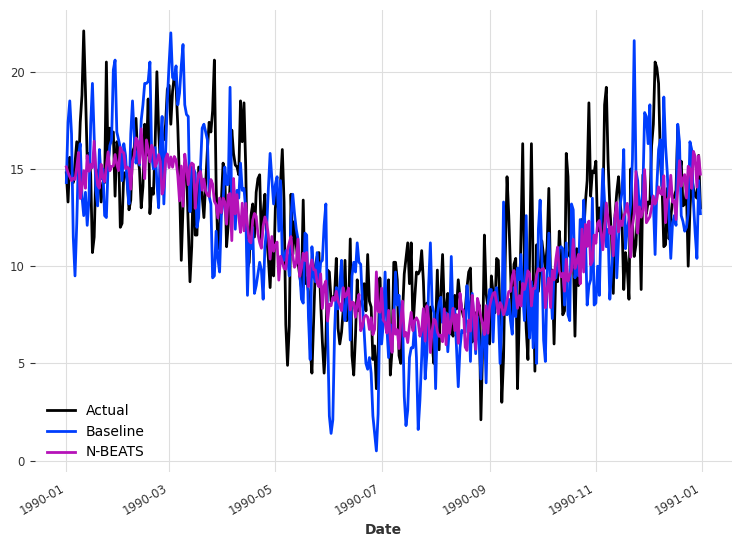

In [17]:
test.plot(label='Actual')
pred_naive.plot(label='Baseline')
pred_nbeats.plot(label='N-BEATS')

## N-BEATS with covariates 

In [18]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

cov = dt_attr(series.time_index, 'month', dtype=np.float32)

In [19]:
cov_scaler = Scaler()

scaled_cov = cov_scaler.fit_transform(cov)

train_scaled_cov, test_scaled_cov = scaled_cov[:-365], scaled_cov[-365:]

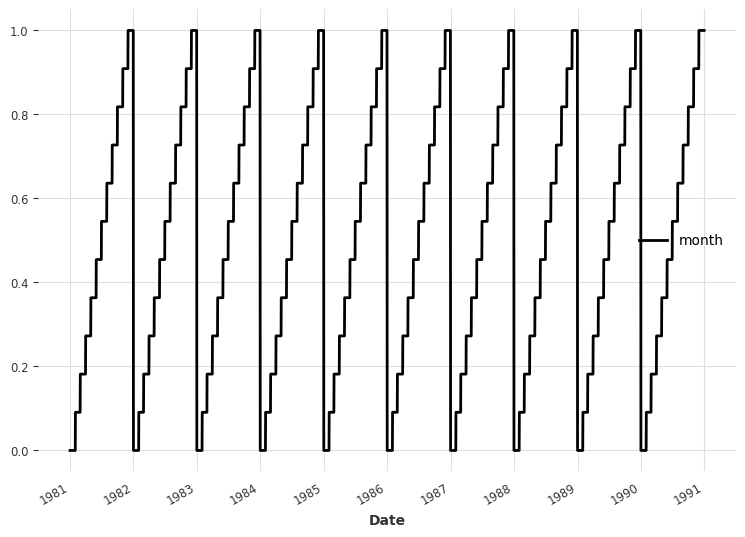

In [21]:
scaled_cov.plot()

In [23]:
nbeats_cov = NBEATSModel(
    input_chunk_length=365, 
    output_chunk_length=365,
    generic_architecture=True,
    random_state=42)

nbeats_cov.fit(
    scaled_train,
    past_covariates=scaled_cov,
    epochs=15
)

2023-01-26 18:43:29 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2023-01-26 18:43:29 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2023-01-26 18:43:29 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2023-01-26 18:43:29 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2023-01-26 18:43:29 pytorch_lightning.callbacks.model_summary INFO: 
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 11.9 M
---------------------------------------------------
11.9 M    Trainable params
5.7 K     Non-trainable params
11.9 M    Total params
95.002    Total estimated model params size (MB)


Epoch 14: 100%|████████████████████████████████████████| 80/80 [00:16<00:00,  4.85it/s, loss=0.0116, train_loss=0.0113]

2023-01-26 18:47:40 pytorch_lightning.utilities.rank_zero INFO: `Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|████████████████████████████████████████| 80/80 [00:16<00:00,  4.85it/s, loss=0.0116, train_loss=0.0113]


In [24]:
scaled_pred_nbeats_cov = nbeats_cov.predict(past_covariates=scaled_cov, n=365)

pred_nbeats_cov = train_scaler.inverse_transform(scaled_pred_nbeats_cov)

Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.93it/s]


### Evaluation 

In [25]:
mae_nbeats_cov = mae(test, pred_nbeats_cov)

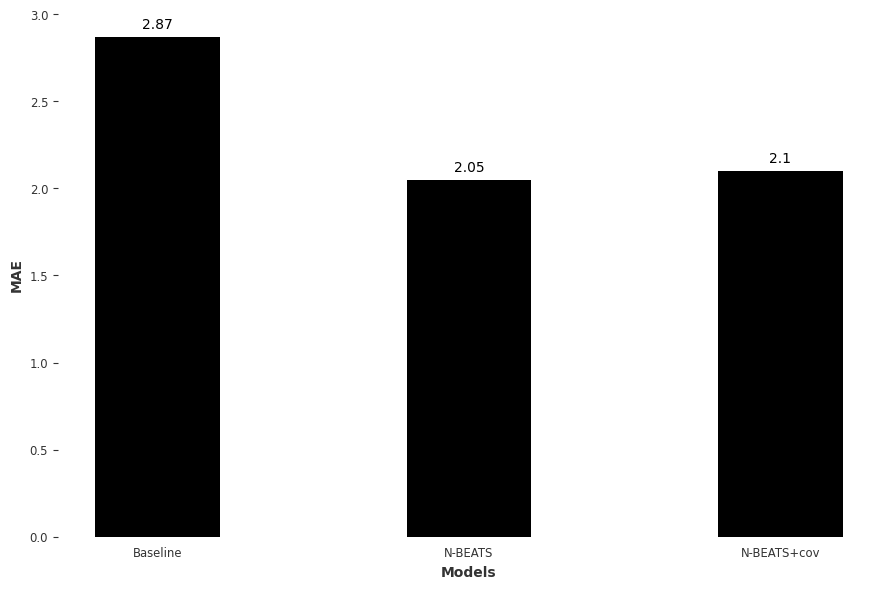

In [26]:
fig, ax = plt.subplots()

x = ['Baseline', 'N-BEATS', 'N-BEATS+cov']
y = [naive_mae, nbeats_mae, mae_nbeats_cov]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')
ax.grid(False)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

### Plot predictions 

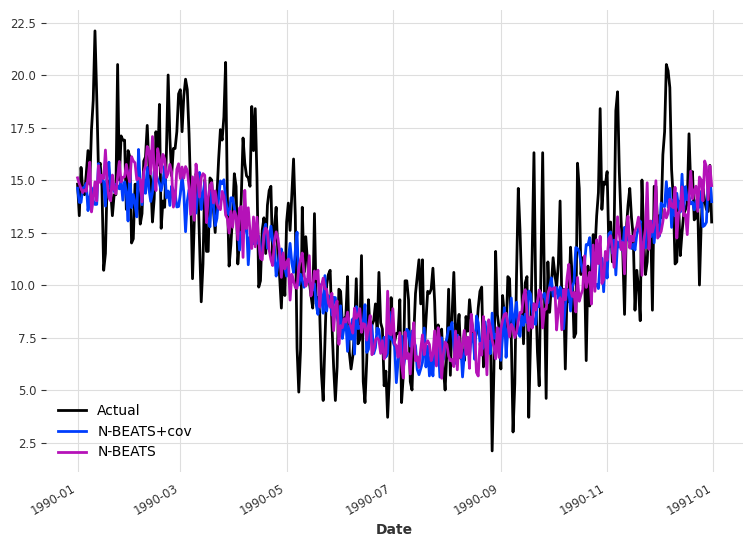

In [27]:
test.plot(label='Actual')
pred_nbeats_cov.plot(label='N-BEATS+cov')
pred_nbeats.plot(label='N-BEATS')